# V928 Tau - Orbital Analysis

Using the light curve data, the parameters obtained from the eclipse fit and all the remaining photometry from ground surveys we can do orbital analysis. This is based in large part on the size of the disk, stability criteria and the transverse velocity found.

1) the transverse velocity tells you what the circular velocity would be for a Keplerian orbit. If this is not believeable we can attempt to "fit" an elliptical orbit by constructing a grid of secondary masses and periods

2) the size of the disk can give a minimum mass constraint based on the formula for the Hill radius of the secondary

3) we know that the orbit has to have a semi-major axis that is small enough to bind it to a single component of the V928 Tau binary

In [1]:
import os
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import orbital_analysis as oa

%matplotlib inline

## Stellar and Disk Parameters

Here we define the stellar parameters (magnetic and standard models help determine the mass and radius is determined from $v \sin i$ values) and disk parameters from the eclipse modeling notebook.

### Stellar Parameters

In [2]:
# V928 Tau A
M1m = 0.700 * u.Msun
M1s = 0.450 * u.Msun
R1  = 1.376 * u.Rsun

# V928 Tau B
M2m = 0.700 * u.Msun
M2s = 0.460 * u.Msun
R2  = 1.296 * u.Rsun

# V928 Tau separation
a_bin = 32 * u.au

# compound lists
Ms = [M1m, M1s, M2m, M2s]
Rs = [R1, R1, R2, R2]
host_lbls = ['A (magnetic)', 'A (standard)', 'B (magnetic)', 'B (standard)']

### Disk Parameters

In [19]:
# load parameters
#pb = np.load('/Users/dmvandam/SurfDrive/phd/projects/v928tau/models/eclipse_model_hlm.npy')
pb = np.load('models/best_fits/fuzzy_translucent_disk.npy')
saveroot = 'plots/parameters/fuzzy_translucent_new/'
if not os.path.exists(saveroot):
    os.mkdir(saveroot)

# extract parameters
if len(pb) == 6:
    rdisk, b, inc, tilt, vt, dt = pb
    redge = tau_edge = tau_disk = 0
elif len(pb) == 7:
    rdisk, b, inc, tilt, vt, dt, tau_disk = pb
    redge = tau_edge = 0
else:
    rdisk, redge, b, inc, tilt, vt, dt, tau_disk, tau_edge = pb
    
# calculate total size
rtot = rdisk + redge

# transform to SI units
r1 = (rtot * R1).to(u.au)
r2 = (rtot * R2).to(u.au)
rs = [r1, r1, r2, r2]

# convert to km/s
v1 = (vt * R1 / u.day).to(u.km / u.s)
v2 = (vt * R2 / u.day).to(u.km / u.s)
vs = [v1, v1, v2, v2]

## Circular Orbit

We start with the limiting case, where we assume that the secondary is on a circular orbit. $\ \ \ \ \ \ \ \ m\frac{v_{circ}^2}{r} = \frac{GmM}{r^2} \rightarrow r = \frac{GM}{v_{circ}^2}$

In [20]:
# find semi-major axis for a keplerian orbit
a_circs = []
for M, v, lbl in zip(Ms, vs, host_lbls):
    a_circ = oa.vcirc_to_a(M, 0*u.Mjup, v)
    print('semimajor axis %s: %.4f %s' % (lbl, a_circ.value, a_circ.unit))
    a_circs.append(a_circ)

semimajor axis A (magnetic): 0.0723 AU
semimajor axis A (standard): 0.0465 AU
semimajor axis B (magnetic): 0.0815 AU
semimajor axis B (standard): 0.0536 AU


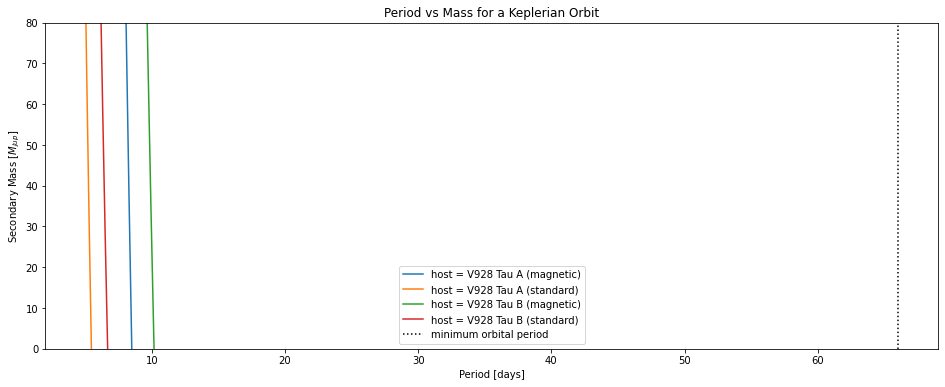

In [21]:
# find the relevant periods (which depend on mass of the secondary)
Mp = np.linspace(0, 80, 801) * u.Mjup
Ps = []

plt.figure(figsize=(16,6))
plt.title('Period vs Mass for a Keplerian Orbit')
for ac, M, lbl in zip(a_circs, Ms, host_lbls):
    P = oa.a_to_P(ac, M, Mp).to(u.day)
    plt.plot(P, Mp, label='host = V928 Tau %s' % lbl)
    Ps.append(P)
plt.axvline(x=66, label='minimum orbital period', color='k', ls=':')
plt.ylim(0, 80)
plt.ylabel('Secondary Mass [$M_{jup}$]')
plt.xlabel('Period [days]')
plt.legend()
plt.show()

This plot implies that for a circular orbit with a period exceeding 66 days the mass of the secondary must be negative, which is of course impossible. We must assume that the orbit is thus eccentric.

## Eccentric Orbit

Now we need to construct mass, period grids to do "simulations" to see what possible orbital configurations are possible. Our basic constraints are as follows:

1) we have a periastron velocity given by the eclipse fit

2) the apastron distance must be $r_{ap} <= 3.2 AU$, this being 10% of the binary separation

3) the Hill radius must exceed the size of the disk with a stability factor ($0.3 \, r_{Hill} > r_{disk}$)

4) the disk must be stable at periastron passage (so $r_{Hill}$ evaluated at $r_{peri}$)

5) the period must exceed 66 days ($P > 66$ days)

### Parameter Constraints

In [22]:
# parameter limits
rap_max = a_bin * 0.1                       # stability of orbit
rh_min  = [r1/0.3, r1/0.3, r2/0.3, r2/0.3] # minimum Hill radii

# companion limits
P_min  = 66 * u.day                         # otherwise visible in K2 photometry
Mp_min = 0  * u.Mjup                        # the planet can't have mass less than 0
Mp_max = 80 * u.Mjup                        # the planet shouldn't exceed the substellar mass limit

# eclipse parameters
t_ecl = 0.5 * u.day                         # eclipse duration
d_ecl = 0.6                                 # eclipse depth

### Setting-up Mass and Period Grids

In [23]:
# we make a mass grid
Mp = np.linspace(Mp_min, Mp_max, int((Mp_max - Mp_min).value) + 1)

# we can determine the maximum period by saying that the semi-major axis in a circular orbit may not exceed rap_max
P_max = 0
for M in Ms:
    P = np.ceil(oa.a_to_P(rap_max, M, Mp_min).to(u.day)) # round number of days
    if P > P_max:
        P_max = P

# we make a period grid
P = np.linspace(P_min, P_max, int((P_max - P_min).value) + 1)

# we print the parameters
print('Mass range is:   %.1f - %.1f %s' % (Mp_min.value, Mp_max.value, Mp.unit))
print('Period range is: %d - %d %s' % (P_min.value, P_max.value, P.unit))

Mass range is:   0.0 - 80.0 jupiterMass
Period range is: 66 - 3117 d


### Determining Parameters

Here we look at the parameters themselves and see if there is a large amount of parameter space that is blocked out by the constraints. The simplest constraints are those on $r_{Hill}$ and $r_{ap}$ as these are not dependent on the data collected from ground surveys. We therefore start with these constraints.

In [24]:
# create lists
es   = []
rps  = []
raps = []
rhs  = []

# populate lists
for M, vp in zip(Ms, vs):
    e, rp, rap, rh = oa.get_parameters(M, Mp, P, vp)
    # append
    es.append(e)
    rps.append(rp)
    raps.append(rap)
    rhs.append(rh)


### Determining Extent of Period and Mass

The most obvious parameter to check the apastron distance $r_{ap}$ as this likely has the largest cut-off due to a strict constraint, but we enforce the constraint on apastron distance and the Hill radius.

In [25]:
# determine r_ap and r_Hill masks
rap_masks = []
rh_masks  = []
for rap, r, rh in zip(raps, rs, rhs):
    # define
    rap_mask = rap.value <= 3.2
    rh_mask  = r.value <= 0.3 * rh.value
    # append
    rap_masks.append(rap_mask)
    rh_masks.append(rh_mask)

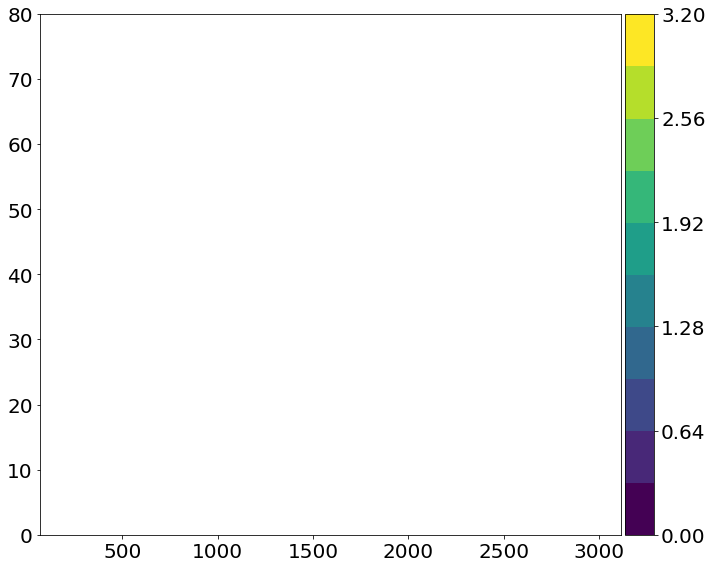

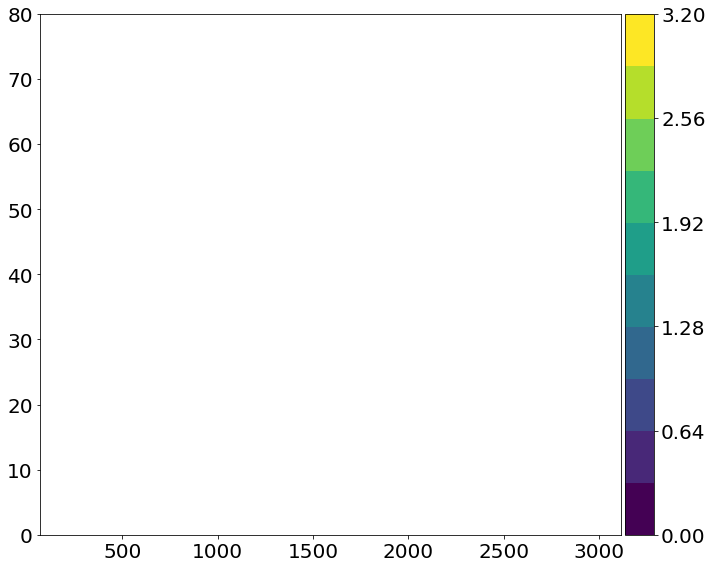

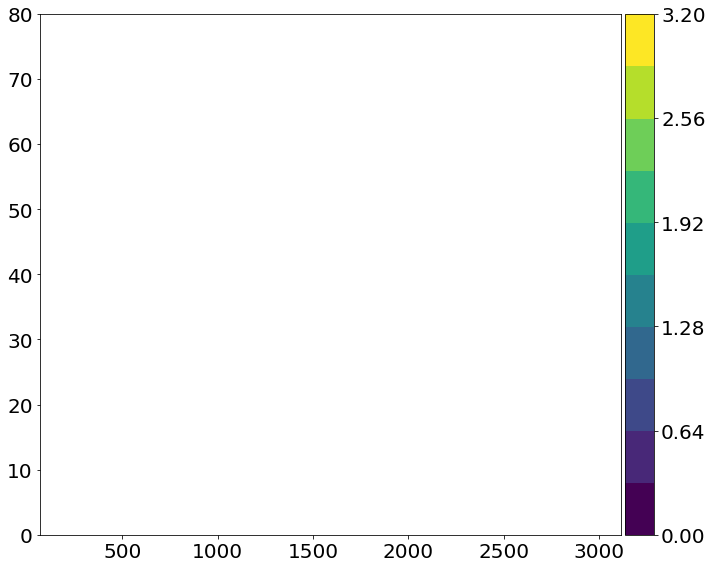

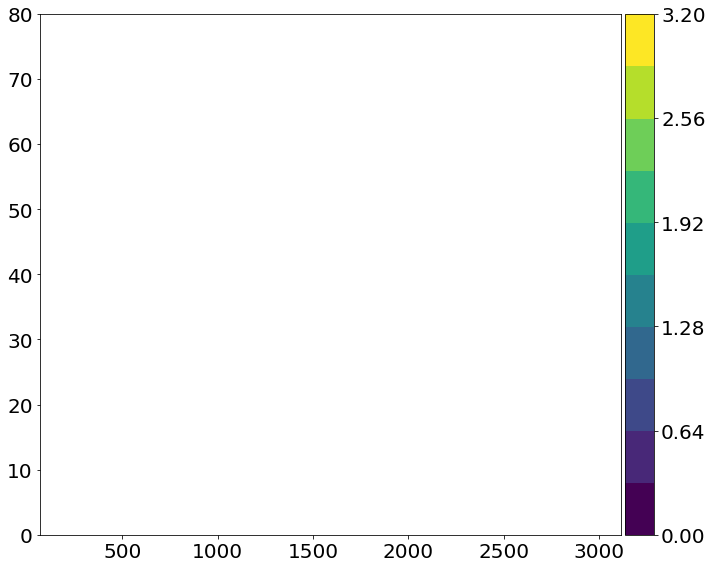

In [26]:
# plot all the different versions of one parameter to see the extent of P and Mp
param_lbls = ['$%smag, A}$', '$%sstd, A}$', '$%smag, B}$', '$%sstd, B}$']

for rap, lbl, rap_m, rh_m in zip(raps, param_lbls, rap_masks, rh_masks): 
    oa.plot_parameter(P, Mp, rap, lbl % 'r_{ap, ', rap_mask=rap_m, rh_mask=rh_m, vmin=0, vmax=3.2)

From the above plots it is clear that the total limit for period is about $1200 \, \mathrm{days}$, and that the lower companion mass limit is about $2 \, M_{jup}$. The period will be cut off at this value, but mass will continue to extend down to $0 \, M_{jup}$ as we feel information is otherwise lost. The resolution of the grid can then be increased tenfold.

# Parameter Maps

Here all the parameter maps are prepared with a high resolution grid for 4 situations: V928 Tau A and B, standard and magnetic models. The parameters considered are the apastron distance $r_{ap}$, periastron distance $r_{peri}$ the eccentricity $e$ and the Hill radius $r_H$.

In [27]:
# maximum from above plots
Mp_minn = 0 * u.Mjup
Mp_maxn = 80 * u.Mjup
P_minn = 0 * u.day
P_maxn = 1200 * u.day

# new resolution grid
Mpn = np.linspace(Mp_minn, Mp_maxn, 10 * int((Mp_maxn - Mp_minn).value) + 1)
Pn  = np.linspace(P_minn, P_maxn, 10 * int((P_maxn - P_minn).value) + 1)

In [28]:
# get the parameters
en   = []
rpn  = []
rapn = []
rhn  = []

# populate lists
for M, vp in zip(Ms, vs):
    e, rp, rap, rh = oa.get_parameters(M, Mpn, Pn, vp)
    # append
    en.append(e)
    rpn.append(rp)
    rapn.append(rap)
    rhn.append(rh)

In [29]:
# determine r_ap and r_Hill masks
rap_maskn = []
rh_maskn  = []
for rap, r, rh in zip(rapn, rs, rhn):
    # define
    rap_mask = rap.value <= 3.2
    rh_mask  = r.value <= 0.3 * rh.value
    # append
    rap_maskn.append(rap_mask)
    rh_maskn.append(rh_mask)

In [30]:
# save labels
savebases = ['%s_Amag.png', '%s_Astd.png', '%s_Bmag.png', '%s_Bstd.png']

## Apastron Passage - $r_{ap}$

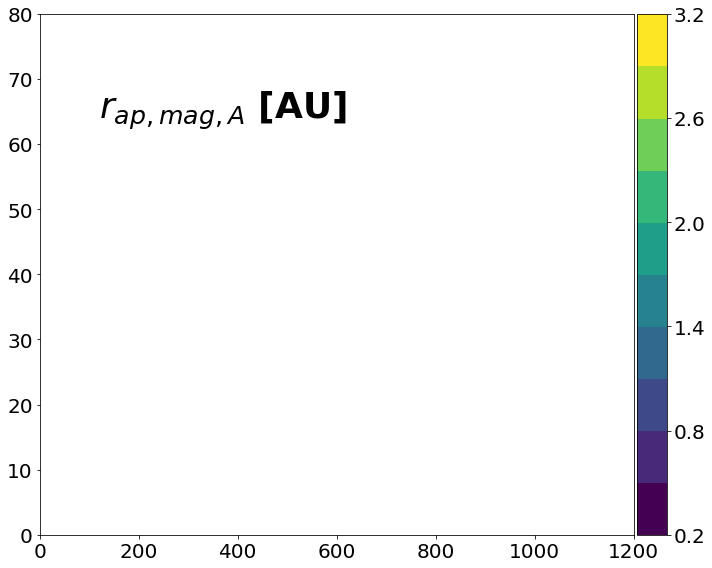

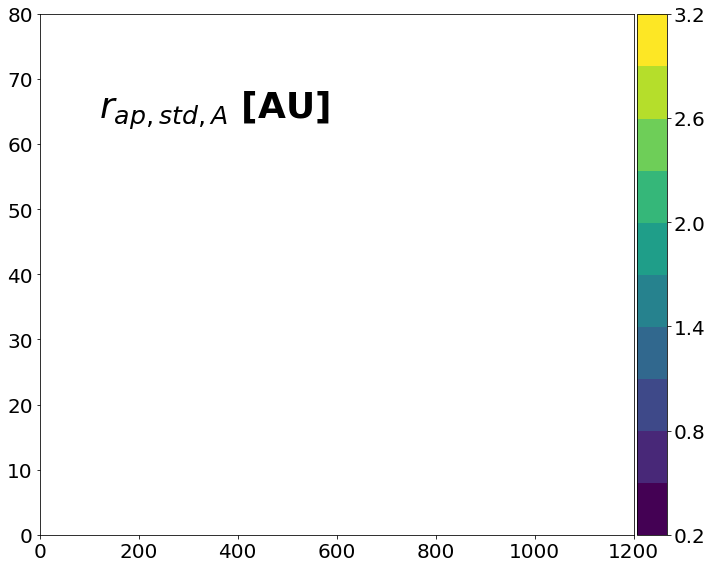

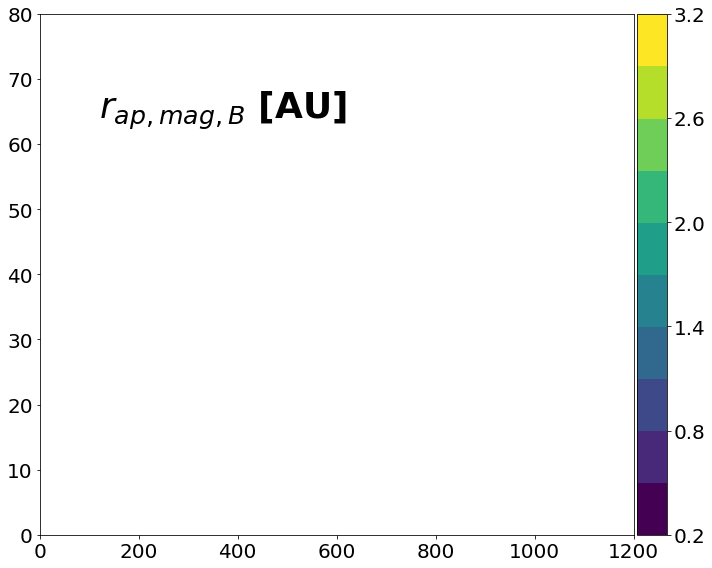

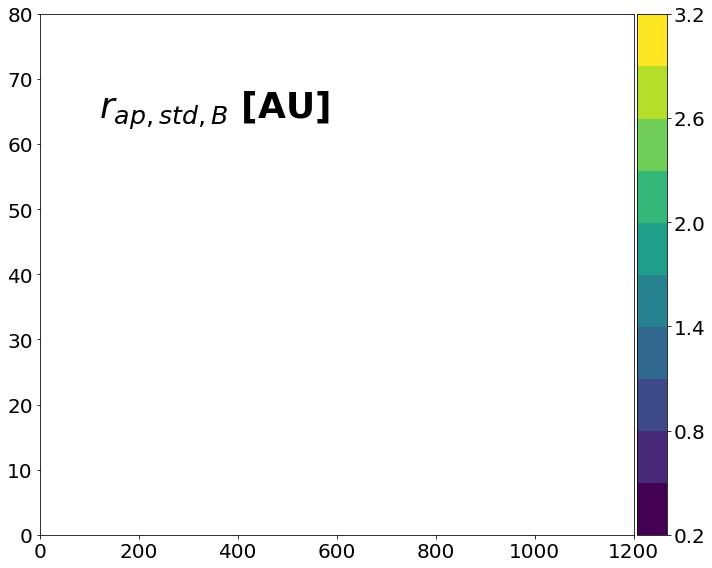

In [31]:
for rap, lbl, rap_m, rh_m, sb in zip(rapn, param_lbls, rap_maskn, rh_maskn, savebases):
    savename = saveroot + sb % 'rap'
    param = lbl % 'r_{ap, '
    oa.plot_parameter(Pn, Mpn, rap, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.2, vmax=3.2,
                      savename=savename, title_color='k')

## Periastron Passage - $r_p$

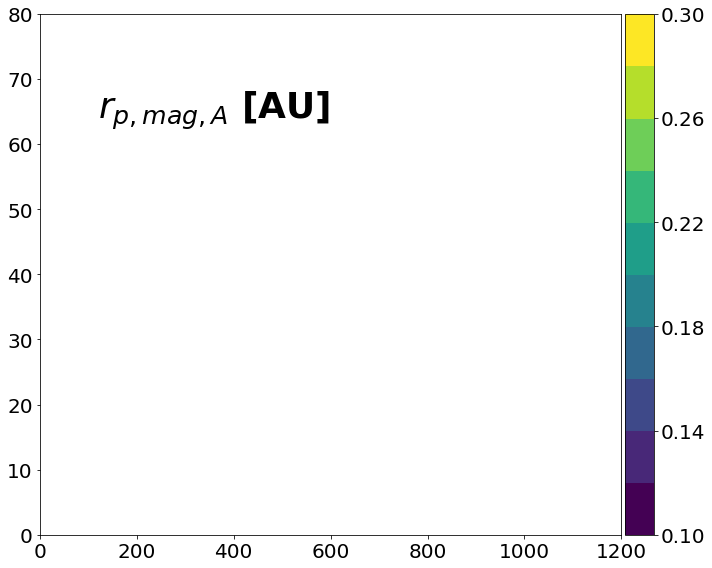

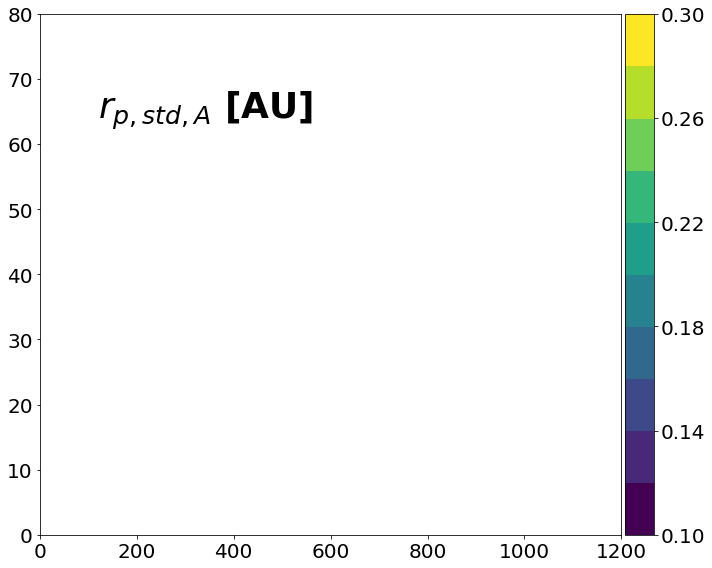

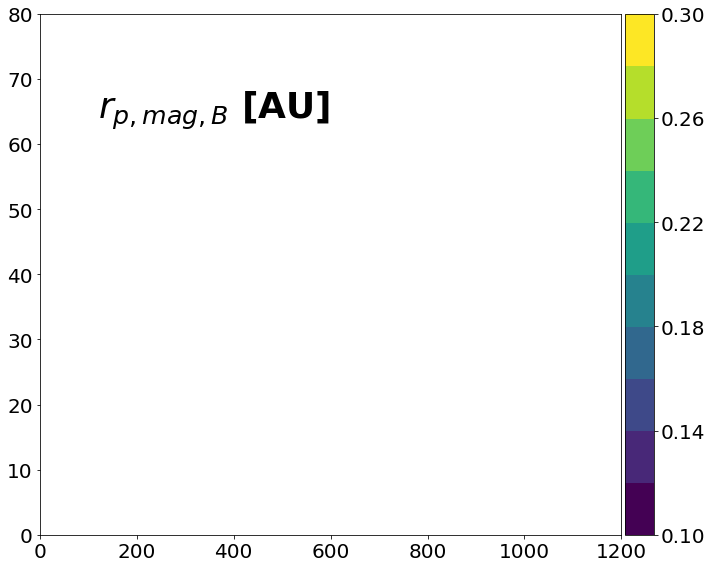

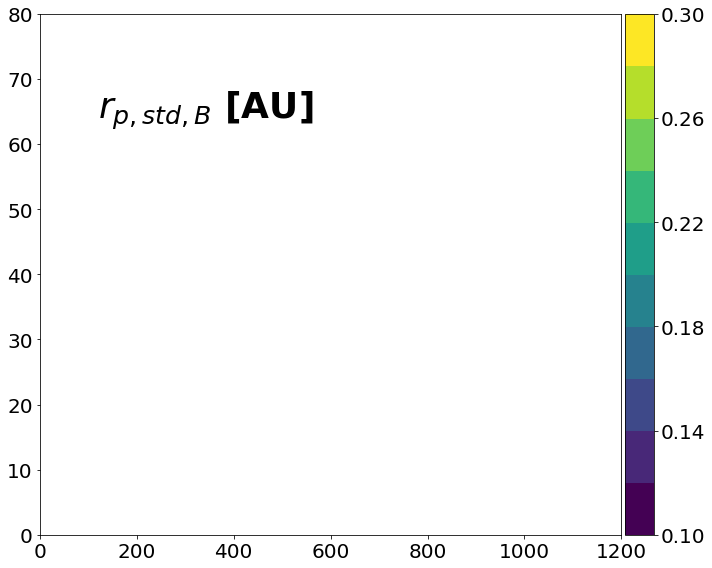

In [32]:
for rp, lbl, rap_m, rh_m, sb in zip(rpn, param_lbls, rap_maskn, rh_maskn, savebases): 
    save = saveroot + sb % 'rp'
    param = lbl % 'r_{p, '
    oa.plot_parameter(Pn, Mpn, rp, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.1, vmax=0.3, 
                      lvls=10, tick_num=6, savename=save, title_color='k')

## Hill Radius - $r_H$

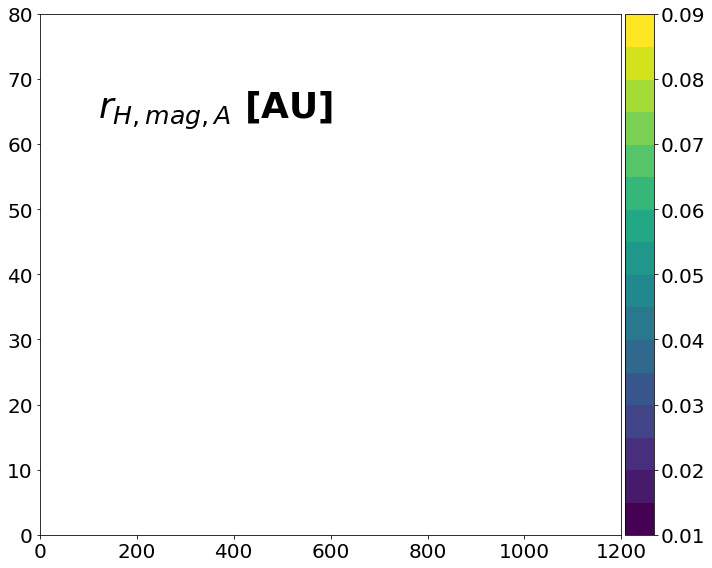

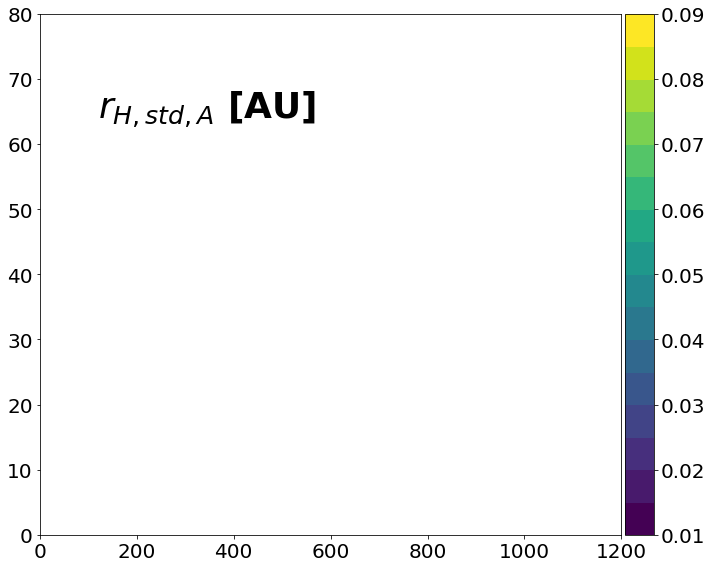

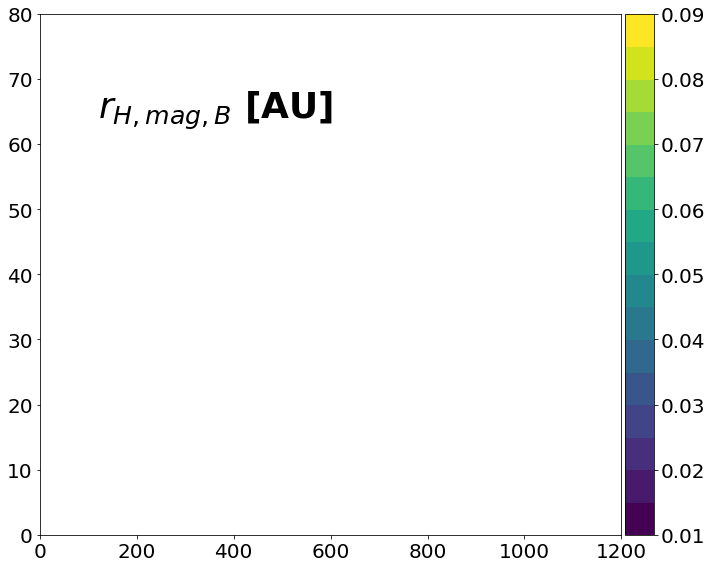

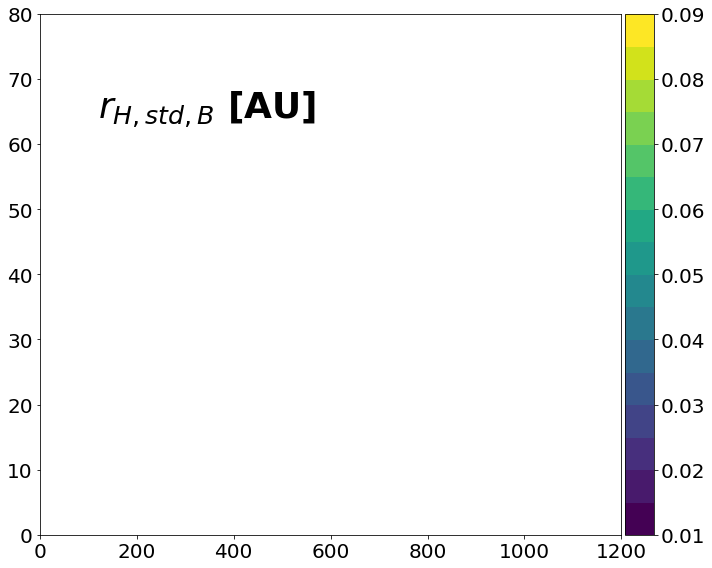

In [33]:
for rh, lbl, rap_m, rh_m, sb in zip(rhn, param_lbls, rap_maskn, rh_maskn, savebases):
    save = saveroot + sb % 'rh'
    param = lbl % 'r_{H, '
    oa.plot_parameter(Pn, Mpn, rh, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.01, vmax=0.09, 
                      lvls=16, tick_num=9, savename=save, title_color='k')

## Eccentricity - $e$

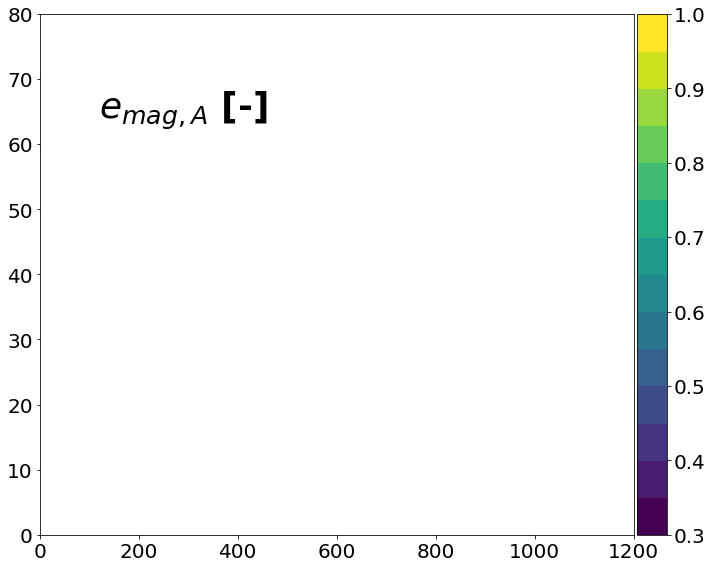

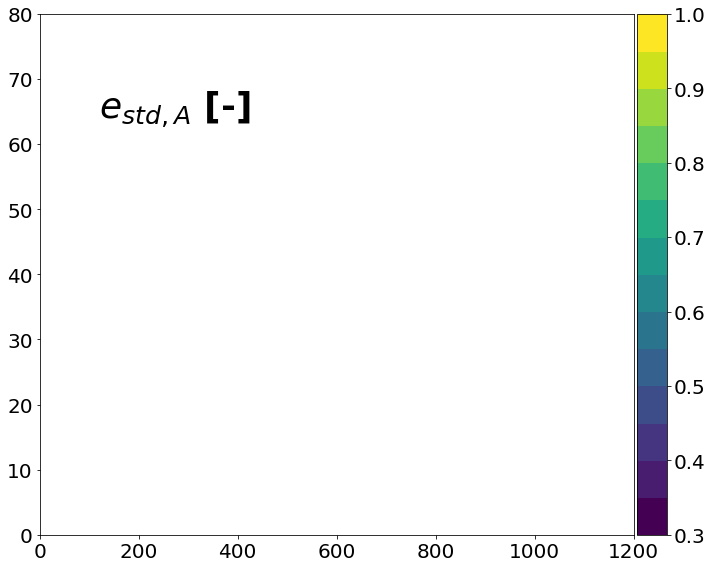

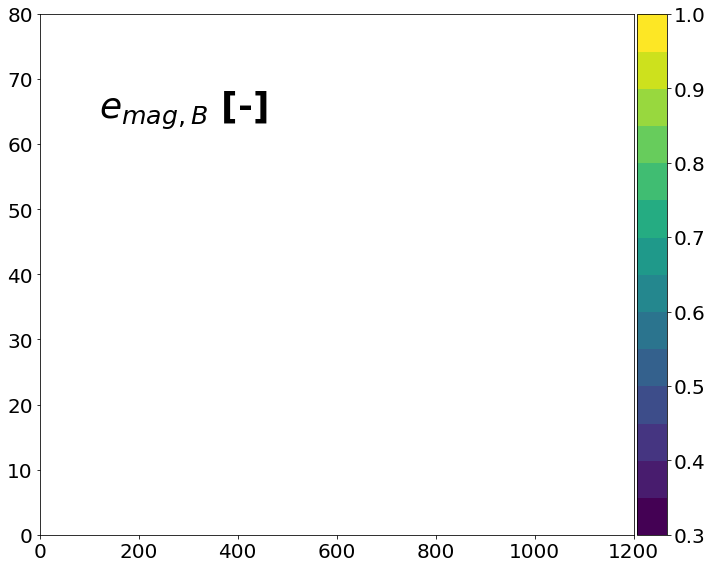

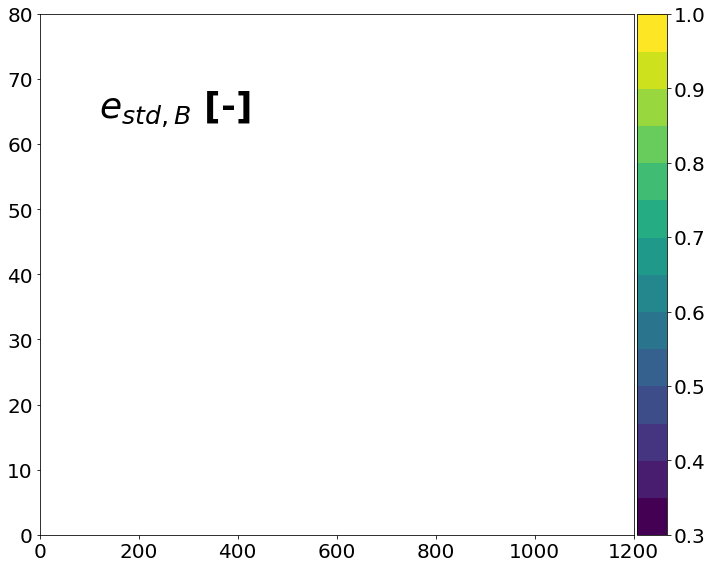

In [34]:
for e, lbl, rap_m, rh_m, sb in zip(en, param_lbls, rap_maskn, rh_maskn, savebases):
    save = saveroot + sb % 'e'
    param = lbl % 'e_{'
    oa.plot_parameter(Pn, Mpn, e, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.3, vmax=1, 
                      lvls=14, tick_num=8, savename=save, title_color='k')